In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
a = np.load("../data/6-parameter-maps/cosmo_params_all_collage_flask_6cosmo_n625_jr0_wSN0_jz3.npz.npy", allow_pickle=True)

In [3]:
print(a.shape)
print(a[0])
print(a[1000])

(639375, 6)
[ 3.00000000e-01  7.30000000e+01  9.70000000e-01  9.00000000e-01
 -1.16650000e+00  5.77880859e-02]
[ 2.45214844e-01  6.88911133e+01  9.59697266e-01  7.90869141e-01
 -1.05946362e+00  4.63549805e-02]


In [4]:
b = np.load("../data/6-parameter-maps/maps_all_collage_flask_6cosmo_n625_jr0_wSN0_jz3.npz.npy", allow_pickle=True)

In [5]:
b.shape

(639375, 66, 66)

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import os
from datetime import datetime
import tensorflow_probability as tfp
tfd = tfp.distributions

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, PROGRESS_EPOCH=50):
        self.PROGRESS_EPOCH = PROGRESS_EPOCH
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.PROGRESS_EPOCH == 0:
            print(f"{datetime.now().strftime('%H:%M:%S')}, epoch {epoch}: ", end="")
            for key, val in logs.items():
                print(f"{key}: {val:.3f}", end= "\t")
            print()

tf.config.list_physical_devices('GPU')

2023-04-23 21:55:23.904856: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 21:55:24.337932: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 21:55:24.340000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 21:55:26.361974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-23 21:55:39.744697: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[]

In [7]:
num_samples = len(a)
train_split, val_split, test_split = int(0.80*num_samples), \
            int(0.10*num_samples), int(0.10*num_samples) + 1
    
print(train_split, val_split, test_split, train_split+val_split+test_split)

train_x, val_x, test_x = np.split(b, [train_split, train_split+val_split])
train_y, val_y, test_y = np.split(a, [train_split, train_split+val_split])

print(train_x.shape, val_x.shape, test_x.shape)
print(train_y.shape, val_y.shape, test_y.shape)

output_num = 6

# train_y, val_y, test_y = train_y[:,:2], val_y[:,:2], test_y[:,:2]
print(train_y.shape, val_y.shape, test_y.shape)

511500 63937 63938 639375
(511500, 66, 66) (63937, 66, 66) (63938, 66, 66)
(511500, 6) (63937, 6) (63938, 6)
(511500, 6) (63937, 6) (63938, 6)


In [8]:
from sklearn.preprocessing import StandardScaler
scaler_y = StandardScaler()
scaler_y.fit(a)

print(np.mean(train_y, axis=0))
print(np.mean(val_y, axis=0))
print(np.mean(test_y, axis=0))

train_y, val_y, test_y = scaler_y.transform(train_y), \
        scaler_y.transform(val_y), scaler_y.transform(test_y) 

print(np.mean(train_y, axis=0))
print(np.mean(val_y, axis=0))
print(np.mean(test_y, axis=0))
print(np.std(train_y, axis=0))
print(np.std(val_y, axis=0))
print(np.std(test_y, axis=0))

[ 2.99260562e-01  7.29951974e+01  9.70789746e-01  8.10708490e-01
 -8.97706212e-01  5.20659452e-02]
[ 2.99257631e-01  7.29948627e+01  9.70781244e-01  8.10700120e-01
 -8.97733104e-01  5.21116779e-02]
[ 2.99263492e-01  7.29955321e+01  9.70798248e-01  8.10716859e-01
 -8.97679320e-01  5.20202132e-02]
[ 7.62958289e-13 -8.90376721e-13  3.82956315e-11 -3.70502768e-11
  2.30915972e-13 -6.10219379e-11]
[-2.79327083e-05 -6.43455892e-05 -1.46900599e-04 -3.28831422e-05
 -7.60436442e-05  8.00005868e-03]
[ 2.79322730e-05  6.43445810e-05  1.46898378e-04  3.28825538e-05
  7.60424553e-05 -7.99993368e-03]
[1. 1. 1. 1. 1. 1.]
[1.00003295 0.99999437 1.00003557 0.99998524 1.00010165 0.99997582]
[0.99996705 1.00000562 0.99996441 1.00001475 0.99989834 0.99996018]


In [117]:
input_shape = (66, 66, 1) 
# output_num = 6

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.Normalization(),
  tf.keras.layers.Conv2D(4, kernel_size=3, activation='tanh'),
  tf.keras.layers.MaxPooling2D(pool_size=2),
  tf.keras.layers.Conv2D(8, kernel_size=4, activation='tanh'),
  tf.keras.layers.MaxPooling2D(pool_size=2),
  # tf.keras.layers.Conv2D(16, kernel_size=(2, 2), activation='tanh'),
  # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(32, kernel_size=2, activation='tanh'),
  tf.keras.layers.MaxPooling2D(pool_size=2),
  # tf.keras.layers.Conv2D(32, kernel_size=(2, 2), activation='tanh'),
  # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  # tf.keras.layers.Dense(256, activation='tanh'),
  tf.keras.layers.Dense(128, activation='tanh'),
  tf.keras.layers.Dense(64, activation='tanh'),
  tf.keras.layers.Dense(output_num, activation='linear') # assuming 6 output parameters
])

# Compile the model
# model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())
model.compile(loss=tf.keras.losses.LogCosh(), optimizer=tf.keras.optimizers.Adam())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 66, 66, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 8)         520       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                        

In [ ]:
model.fit(train_x, train_y, epochs=50, batch_size=4, verbose=1, callbacks=[CustomCallback(10)])

Epoch 1/50
127875/127875 [==============================] - 815s 6ms/step - loss: 0.2862
Epoch 2/50
127875/127875 [==============================] - 816s 6ms/step - loss: 0.2797
Epoch 3/50
127875/127875 [==============================] - 832s 7ms/step - loss: 0.2786
Epoch 4/50
 41120/127875 [========>.....................] - ETA: 9:41 - loss: 0.2782

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



105838/127875 [=======================>......] - ETA: 2:25 - loss: 0.2782

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 41530/127875 [========>.....................] - ETA: 9:30 - loss: 0.2778

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 98456/127875 [======================>.......] - ETA: 3:16 - loss: 0.2778

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 34790/127875 [=======>......................] - ETA: 10:13 - loss: 0.2777

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 99184/127875 [======================>.......] - ETA: 3:08 - loss: 0.2777

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 36481/127875 [=======>......................] - ETA: 10:00 - loss: 0.2770

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



127875/127875 [==============================] - 852s 7ms/step - loss: 0.2771
Epoch 8/50
127875/127875 [==============================] - 873s 7ms/step - loss: 0.2767
Epoch 9/50
127875/127875 [==============================] - 855s 7ms/step - loss: 0.2767
Epoch 10/50
127875/127875 [==============================] - 865s 7ms/step - loss: 0.2767
Epoch 11/50
127875/127875 [==============================] - 853s 7ms/step - loss: 0.2768
Epoch 12/50
127875/127875 [==============================] - 857s 7ms/step - loss: 0.2769
Epoch 13/50
127875/127875 [==============================] - 859s 7ms/step - loss: 0.2771
Epoch 14/50
 67183/127875 [==============>...............] - ETA: 6:50 - loss: 0.2752

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



127069/127875 [============================>.] - ETA: 5s - loss: 0.2755

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



127875/127875 [==============================] - 864s 7ms/step - loss: 0.2755
Epoch 15/50
127875/127875 [==============================] - 852s 7ms/step - loss: 0.2762
Epoch 16/50
127875/127875 [==============================] - 842s 7ms/step - loss: 0.2765
Epoch 17/50
127875/127875 [==============================] - 856s 7ms/step - loss: 0.2767
Epoch 18/50
127875/127875 [==============================] - 865s 7ms/step - loss: 0.2757
Epoch 19/50
127875/127875 [==============================] - 864s 7ms/step - loss: 0.2765
Epoch 20/50
113226/127875 [=========================>....] - ETA: 1:39 - loss: 0.2766

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



127875/127875 [==============================] - 867s 7ms/step - loss: 0.2770
Epoch 24/50
121094/127875 [===========================>..] - ETA: 46s - loss: 0.2767

316/316 [==============================] - 1s 5ms/step


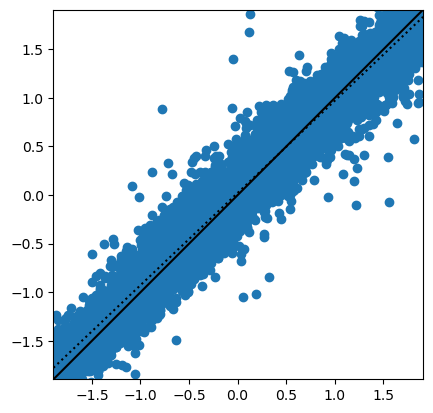

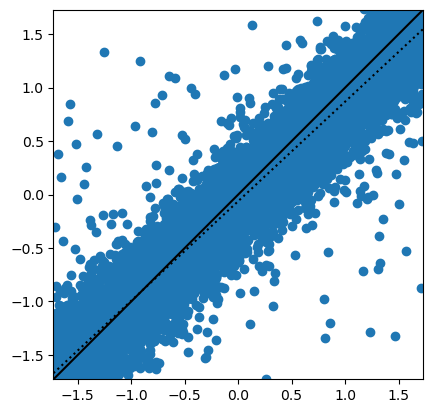

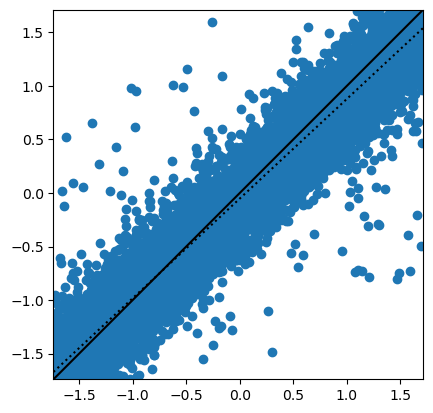

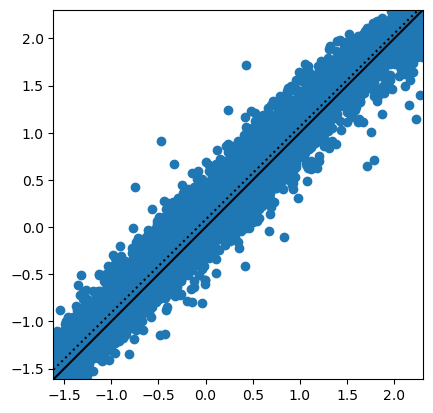

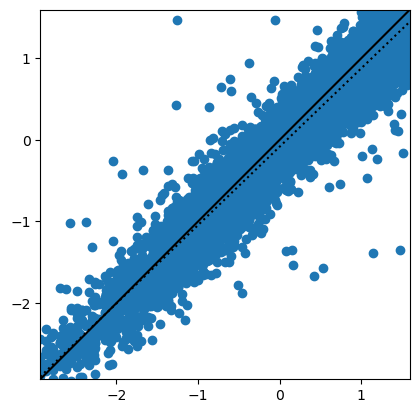

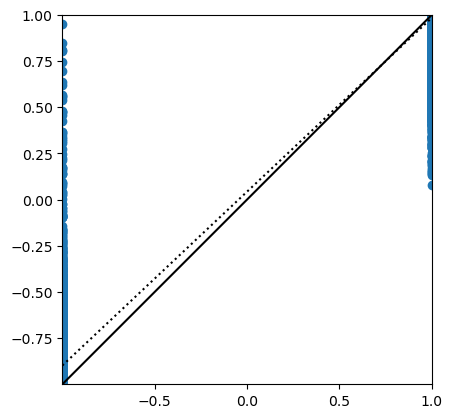

In [122]:
plot_x, plot_y = train_x[:10100], train_y[:10100]
predictions = model.predict(plot_x)
upp_lims = np.nanmax(plot_y, axis=0)
low_lims = np.nanmin(plot_y, axis=0)
for ind, (low_lim, upp_lim) in enumerate(zip(low_lims, upp_lims)):
    p = np.poly1d(np.polyfit(plot_y[:, ind], predictions[:, ind], 1))
    plt.figure()
    plt.scatter(plot_y[:, ind], predictions[:, ind])
    plt.plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
    plt.plot([low_lim, upp_lim], [p(low_lim), p(upp_lim)], color="black", ls=":")
    plt.xlim([low_lim, upp_lim])
    plt.ylim([low_lim, upp_lim])
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()
    plt.close()

In [ ]:
# Train the model
for i in range(1):
    for train_x_batch, train_y_batch in zip(np.split(train_x, 1), np.split(train_y, 1)):
        model.fit(train_x_batch, train_y_batch, epochs=5)
    # model.evaluate(val_x, val_y)

In [48]:
predictions = model.predict(val_x)
model.evaluate(val_x, val_y)

1999/1999 [==============================] - 9s 4ms/step - loss: 0.4003


0.40028005838394165

In [ ]:
input_shape = (66, 66, 1) 

kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                           tf.cast(train_split, dtype=tf.float32))

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tfp.layers.Convolution2DFlipout(filters = 4, kernel_size=(2, 2), padding='valid',
          kernel_divergence_fn=kl_divergence_function, activation=tf.nn.tanh),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    tfp.layers.Convolution2DFlipout(filters = 16, kernel_size=(2, 2), padding='valid',
          kernel_divergence_fn=kl_divergence_function, activation=tf.nn.tanh),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    tfp.layers.Convolution2DFlipout(filters = 16, kernel_size=(2, 2), padding='valid',
          kernel_divergence_fn=kl_divergence_function, activation=tf.nn.tanh),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    tf.keras.layers.Flatten(),
    tfp.layers.DenseFlipout(units = 128,
          kernel_divergence_fn=kl_divergence_function, activation=tf.nn.tanh),
    tfp.layers.DenseFlipout(units = 64,
          kernel_divergence_fn=kl_divergence_function, activation=tf.nn.tanh),
    tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(6)),
    tfp.layers.MultivariateNormalTriL(6)
])

In [ ]:
# Define loss
# temp_ytrue, temp_ypred = None, None
def negloglik(y_true, y_pred):
    # global temp_ytrue, temp_ypred
    # temp_ytrue, temp_ypred = y_true, y_pred
    return -tf.reduce_mean(y_pred.log_prob(y_true))

# Define the optimizer 
optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.2, rho=0.98)
# optimizer=tf.keras.optimizers.Adadelta()

model.compile(optimizer, loss=negloglik, # tf.keras.losses.LogCosh(), # ['mse'], 
              metrics=['mae', 'mse'], experimental_run_tf_function=False)

model.summary()

In [ ]:
model.fit(train_x, train_y, epochs=5, batch_size=2)

In [ ]:
# plot_x, plot_y = train_x, train_y
plot_x, plot_y = val_x, val_y
# plot_x, plot_y = test_x, test_y

n_pred = 50
predictions = np.empty((n_pred, *plot_y.shape))
for i in range(n_pred):
    predictions[i] = model.predict(plot_x, verbose=0)
predictions_best = np.nanmean(predictions, axis=0)
predictions_std = np.nanstd(predictions, axis=0)

upp_lims = np.nanmax(plot_y, axis=0)
low_lims = np.nanmin(plot_y, axis=0)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = [r"$\Omega_m$", r"$\sigma_8$", r"$A_{SN1}$", r"$A_{AGN1}$", r"$A_{SN2}$", r"$A_{AGN2}$"]
for ind, (label, ax, low_lim, upp_lim) in enumerate(zip(labels, axs.ravel(), low_lims, upp_lims)):
    p = np.poly1d(np.polyfit(plot_y[:, ind], predictions_best[:, ind], 1))
    ax.errorbar(plot_y[:, ind], predictions_best[:, ind],  predictions_std[:, ind], marker="d", ls='none', alpha=0.4)
    ax.set_xlabel("true")
    ax.set_ylabel("prediction")
    ax.plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
    ax.plot([low_lim, upp_lim], [p(low_lim), p(upp_lim)], color="black", ls=":")
    ax.set_xlim([low_lim, upp_lim])
    ax.set_ylim([low_lim, upp_lim])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(label)
    ax.grid()
plt.show()
plt.close()